In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torch.utils.data import Subset

import time

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_indices = list(range(10000))
test_indices = list(range(2000))

train_subset = Subset(trainset, train_indices)
test_subset = Subset(testset, test_indices)

batch_size = 4
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)  
testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=0)  

full_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)  
full_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0) 

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [31]:
def convert_to_numpy(dataloader):
    data, labels = [], []
    for i, j in dataloader:
        data.append(i.view(i.size(0), -1).numpy())
        labels.append(j.numpy())
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

X_train, y_train = convert_to_numpy(trainloader)
X_test, y_test = convert_to_numpy(testloader)
X_full_train, y_full_train = convert_to_numpy(full_trainloader)
X_full_test, y_full_test = convert_to_numpy(full_testloader)

In [32]:
def errors_for_train_sizes_knn(X_tr: np.array, y_tr: np.array, X_te: np.array, y_te: np.array, seed: int, train_sizes: list[int], best_k: int) -> tuple[list, list]:
    tr_err_knn = [] 
    te_err_knn = []

    for i in train_sizes:
        knn = KNeighborsClassifier(n_neighbors=best_k)
        knn.fit(X_tr[:i], y_tr[:i])

        train_predictions = knn.predict(X_tr[:i])
        tr_err_knn.append(1 - np.mean(train_predictions == y_tr[:i]))

        test_predictions = knn.predict(X_te)
        te_err_knn.append(1 - np.mean(test_predictions == y_te))

    return tr_err_knn, te_err_knn

In [33]:
def plot_errors_for_train_sizes_knn(tr_err_knn: list, te_err_knn: list, train_sizes: list[int]) -> None:
    plt.semilogx(train_sizes, tr_err_knn, label='Train kNN', marker='x', linestyle='-', color='green')
    plt.semilogx(train_sizes, te_err_knn, label='Test kNN', marker='x', linestyle='--', color='green')

    plt.xlabel('Number of Training Data Points')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title('Learning Curve for kNN (Error)')
    plt.show()

In [34]:
k_values = [1, 5, 10, 50]
k_accuracies = {}

# 5-fold cross-validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies = cross_val_score(knn, X_train, y_train, cv=5)
    k_accuracies[k] = accuracies
    for i in accuracies:
        print(f"k = {k}, accuracy = {i:.4f}")

k = 1, accuracy = 0.2890
k = 1, accuracy = 0.2765
k = 1, accuracy = 0.2710
k = 1, accuracy = 0.2890
k = 1, accuracy = 0.2920
k = 5, accuracy = 0.2900
k = 5, accuracy = 0.2645
k = 5, accuracy = 0.2950
k = 5, accuracy = 0.2985
k = 5, accuracy = 0.2850
k = 10, accuracy = 0.2930
k = 10, accuracy = 0.2715
k = 10, accuracy = 0.2955
k = 10, accuracy = 0.2920
k = 10, accuracy = 0.2815
k = 50, accuracy = 0.2805
k = 50, accuracy = 0.2635
k = 50, accuracy = 0.2795
k = 50, accuracy = 0.2730
k = 50, accuracy = 0.2750


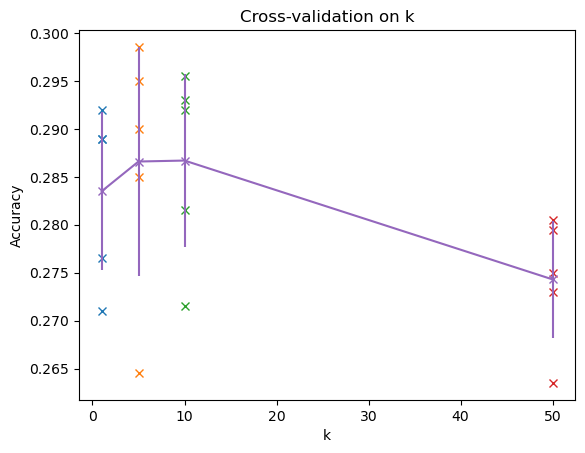

In [35]:
for k in k_values:
    plt.plot([k] * len(k_accuracies[k]), k_accuracies[k], 'x')

mean_accuracies = [np.mean(k_accuracies[k]) for k in k_values]
std_accuracies = [np.std(k_accuracies[k]) for k in k_values]

plt.errorbar(k_values, mean_accuracies, yerr=std_accuracies, fmt='-x')
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

In [36]:
best_k_value = k_values[np.argmax([np.mean(v) for k, v in sorted(k_accuracies.items())])]
print(f"Best k based on cross-validation: {best_k_value}")

Best k based on cross-validation: 10


In [37]:
knn = KNeighborsClassifier(n_neighbors=best_k_value)
knn.fit(X_train, y_train)

train_acc = accuracy_score(y_train, knn.predict(X_train))
test_acc = accuracy_score(y_test, knn.predict(X_test))

print(f"Best k value: {best_k_value}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

Best k value: 10, Train Accuracy: 0.3933, Test Accuracy: 0.2845


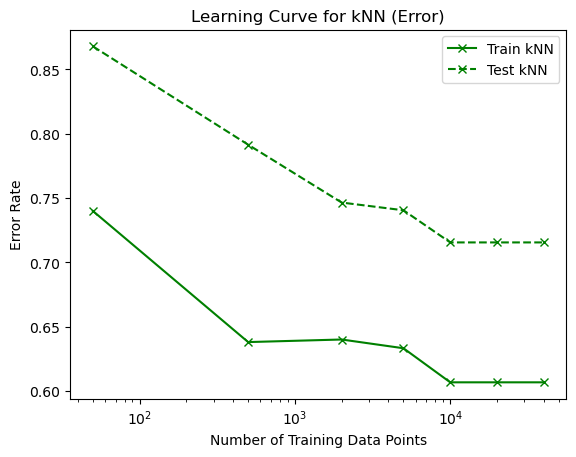

In [38]:
train_sizes = [50, 500, 2000, 5000, 10000, 20000, 40000]

tr_err_knn, te_err_knn = errors_for_train_sizes_knn(X_train, y_train, X_test, y_test, seed, train_sizes, best_k_value)

plot_errors_for_train_sizes_knn(tr_err_knn, te_err_knn, train_sizes)

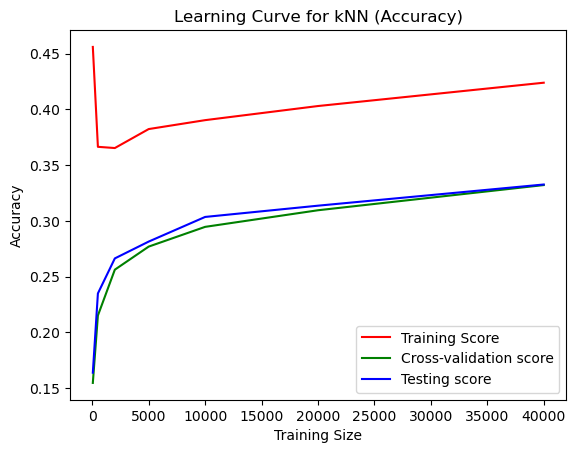

In [39]:
train_sizes_batch = [50, 500, 2000, 5000, 10000, 20000, 40000]

train_sizes_abs, train_scores, validation_scores = learning_curve(
    KNeighborsClassifier(n_neighbors=best_k_value), X_full_train, y_full_train, cv=5, 
    train_sizes=train_sizes_batch, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

testing_scores = []
for i in train_sizes_abs:
    X_train_sub, _, y_train_sub, _ = train_test_split(X_full_train, y_full_train, train_size=i/len(X_full_train), random_state=seed)
    knn = KNeighborsClassifier(n_neighbors=best_k_value)
    knn.fit(X_train_sub, y_train_sub)
    testing_scores.append(accuracy_score(y_full_test, knn.predict(X_full_test)))

test_scores = np.array(testing_scores)

plt.plot(train_sizes_abs, train_scores_mean, color='r', label='Training Score')
plt.plot(train_sizes_abs, validation_scores_mean, color='g', label='Cross-validation score')
plt.plot(train_sizes_abs, test_scores, color='b', label='Testing score')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for kNN (Accuracy)')
plt.legend()
plt.show()

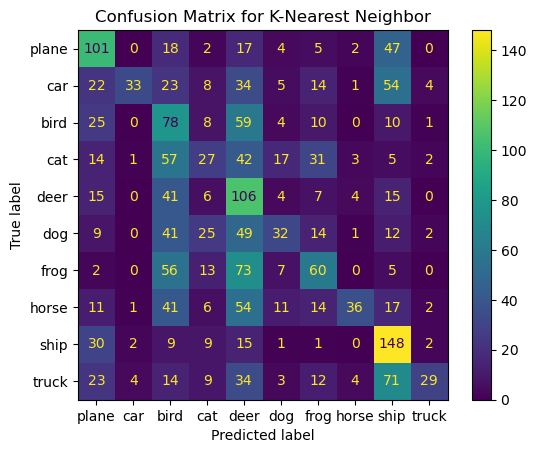

In [40]:
y_prediction = knn.predict(X_test)
confusion_matrix = confusion_matrix(y_test, y_prediction, labels=range(10))
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=classes)
display.plot()
plt.title('Confusion Matrix for K-Nearest Neighbor')
plt.show()

In [41]:
start = time.time()
predictions = knn.predict(X_test)
end = time.time()
prediction_time = end - start
time_per_image = prediction_time / len(X_test)
print(f"Average prediction time per image: {time_per_image:.6f} seconds")

Average prediction time per image: 0.001126 seconds
